# Testing some Whitebox models

We mentionned in class 5 whitebox models easily interpretable. The one we can apply for our binary classification cases are : 
1. Logistic Regression (LR)
2. Decision Tree (DT)
3. GAM

**What makes a model a whitebox model :**
- The algorithm used is straightforward to understand, and we can clearly interpret how the input features are transformed into the output or target variable.
- We can identify the most important features to predict the target variable, and those features are understandable.


In [14]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

In [2]:
cd ..

/Users/vitrac/Desktop/M2 HEC/14 - Algorithm Fairness/fairness-and-explainability


In [3]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Loading the dataset 
df = pd.read_csv('Dataset/df_processed.csv')

# One-hot encoding of categorical columns
columns_to_encode = ["Gender", "EthnicGroup", "WklyStudyHours", "ParentEduc", "LunchType", "ParentMaritalStatus", "PracticeSport"]
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

# Split the dataset
X = df_encoded.drop('Grade', axis=1).copy()
y = df_encoded['Grade'].copy()

# Create train, test, and validation data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# Empty dataframe to store the results of our whitebox models
df_whitebox_results = pd.DataFrame(columns=['Model name', 'Model parameters', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

## 01 - Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Fit a logistic regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
y_val_probabilities = logistic_reg.predict_proba(X_val)[:, 1]
threshold = 0.5
y_val_pred_binary = (y_val_probabilities > threshold).astype(int)

# Calculate evaluation metrics for classification
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_probabilities)

# Append the results to df_whitebox_results
results_dict_logistic = {
    'Model name': ['Logistic Regression'],
    'Model parameters': [logistic_reg.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_logistic = pd.DataFrame(results_dict_logistic)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_logistic], ignore_index=True)

## 02 - Decision Tree

#### A) Without hyperparameter tuning 

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Fit and predict with a Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_val_pred_binary = decision_tree.predict(X_val)

# Calculate evaluation metrics for classification
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_pred_binary)  # If using probabilities, you can calculate AUC-ROC

# Append the results to df_whitebox_results
results_dict_dt = {
    'Model name': ['Decision Tree without tuning'],
    'Model parameters': [decision_tree.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_dt = pd.DataFrame(results_dict_dt)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_dt], ignore_index=True)

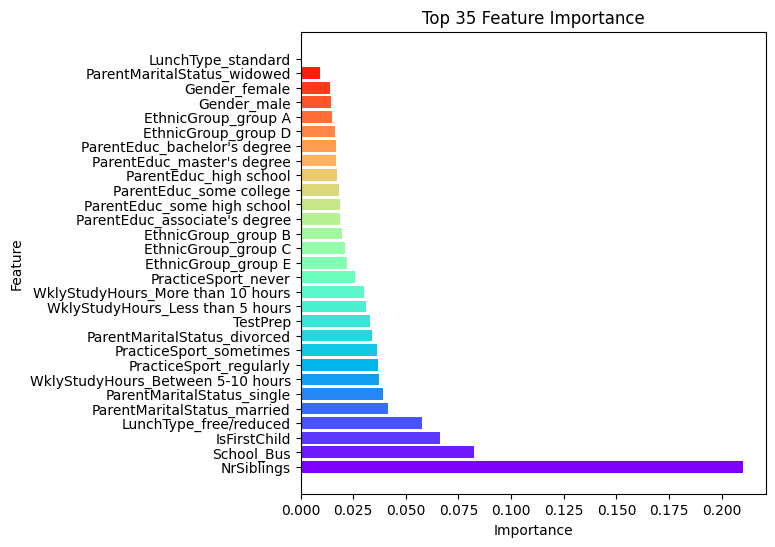

In [27]:
# Get feature importances from the best_decision_tree model
feature_importances = decision_tree.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 35 most important features
top_35_importance_df = importance_df.head(35)

# Plot the feature importances for the top 30 features
colors = cm.rainbow(np.linspace(0, 1, len(top_35_importance_df)))
plt.figure(figsize=(6, 6))
plt.barh(top_35_importance_df['Feature'], top_35_importance_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 35 Feature Importance')
plt.show()

#### B) With hyperparameter tuning 
Rq : Using Bayesian Optimization.

In [8]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score

# Define the objective function to minimize (e.g., negative accuracy)
def objective(params):
    decision_tree = DecisionTreeClassifier(
        random_state = 42,
        max_depth = params['max_depth'],
        min_samples_leaf = params['min_samples_leaf'],
        max_leaf_nodes = params['max_leaf_nodes']
    )
    score = -cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Define the search space for hyperparameters
space = {
    'max_depth': hp.randint('max_depth', 1, 13),  # 1 to 12
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 11), 
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 100),
}
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=200, 
            trials=trials, 
            rstate= np.random.default_rng(seed=42)) 
print("Best Hyperparameters:", best)
best_max_depth = int(best['max_depth'])
best_min_samples_leaf = int(best['min_samples_leaf'])
best_max_leaf_nodes = int(best['max_leaf_nodes'])

# Fit the model and make predictions
best_decision_tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    max_leaf_nodes=best_max_leaf_nodes
)
best_decision_tree.fit(X_train, y_train)
y_val_pred_binary = best_decision_tree.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_pred_binary)

# Append the results to df_whitebox_results
results_dict_dt = {
    'Model name': ['Decision Tree with tuning'],
    'Model parameters': [best_decision_tree.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_dt = pd.DataFrame(results_dict_dt)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_dt], ignore_index=True)

100%|██████████| 200/200 [00:17<00:00, 11.56trial/s, best loss: -0.7624487318075567]
Best Hyperparameters: {'max_depth': 4, 'max_leaf_nodes': 16, 'min_samples_leaf': 2}


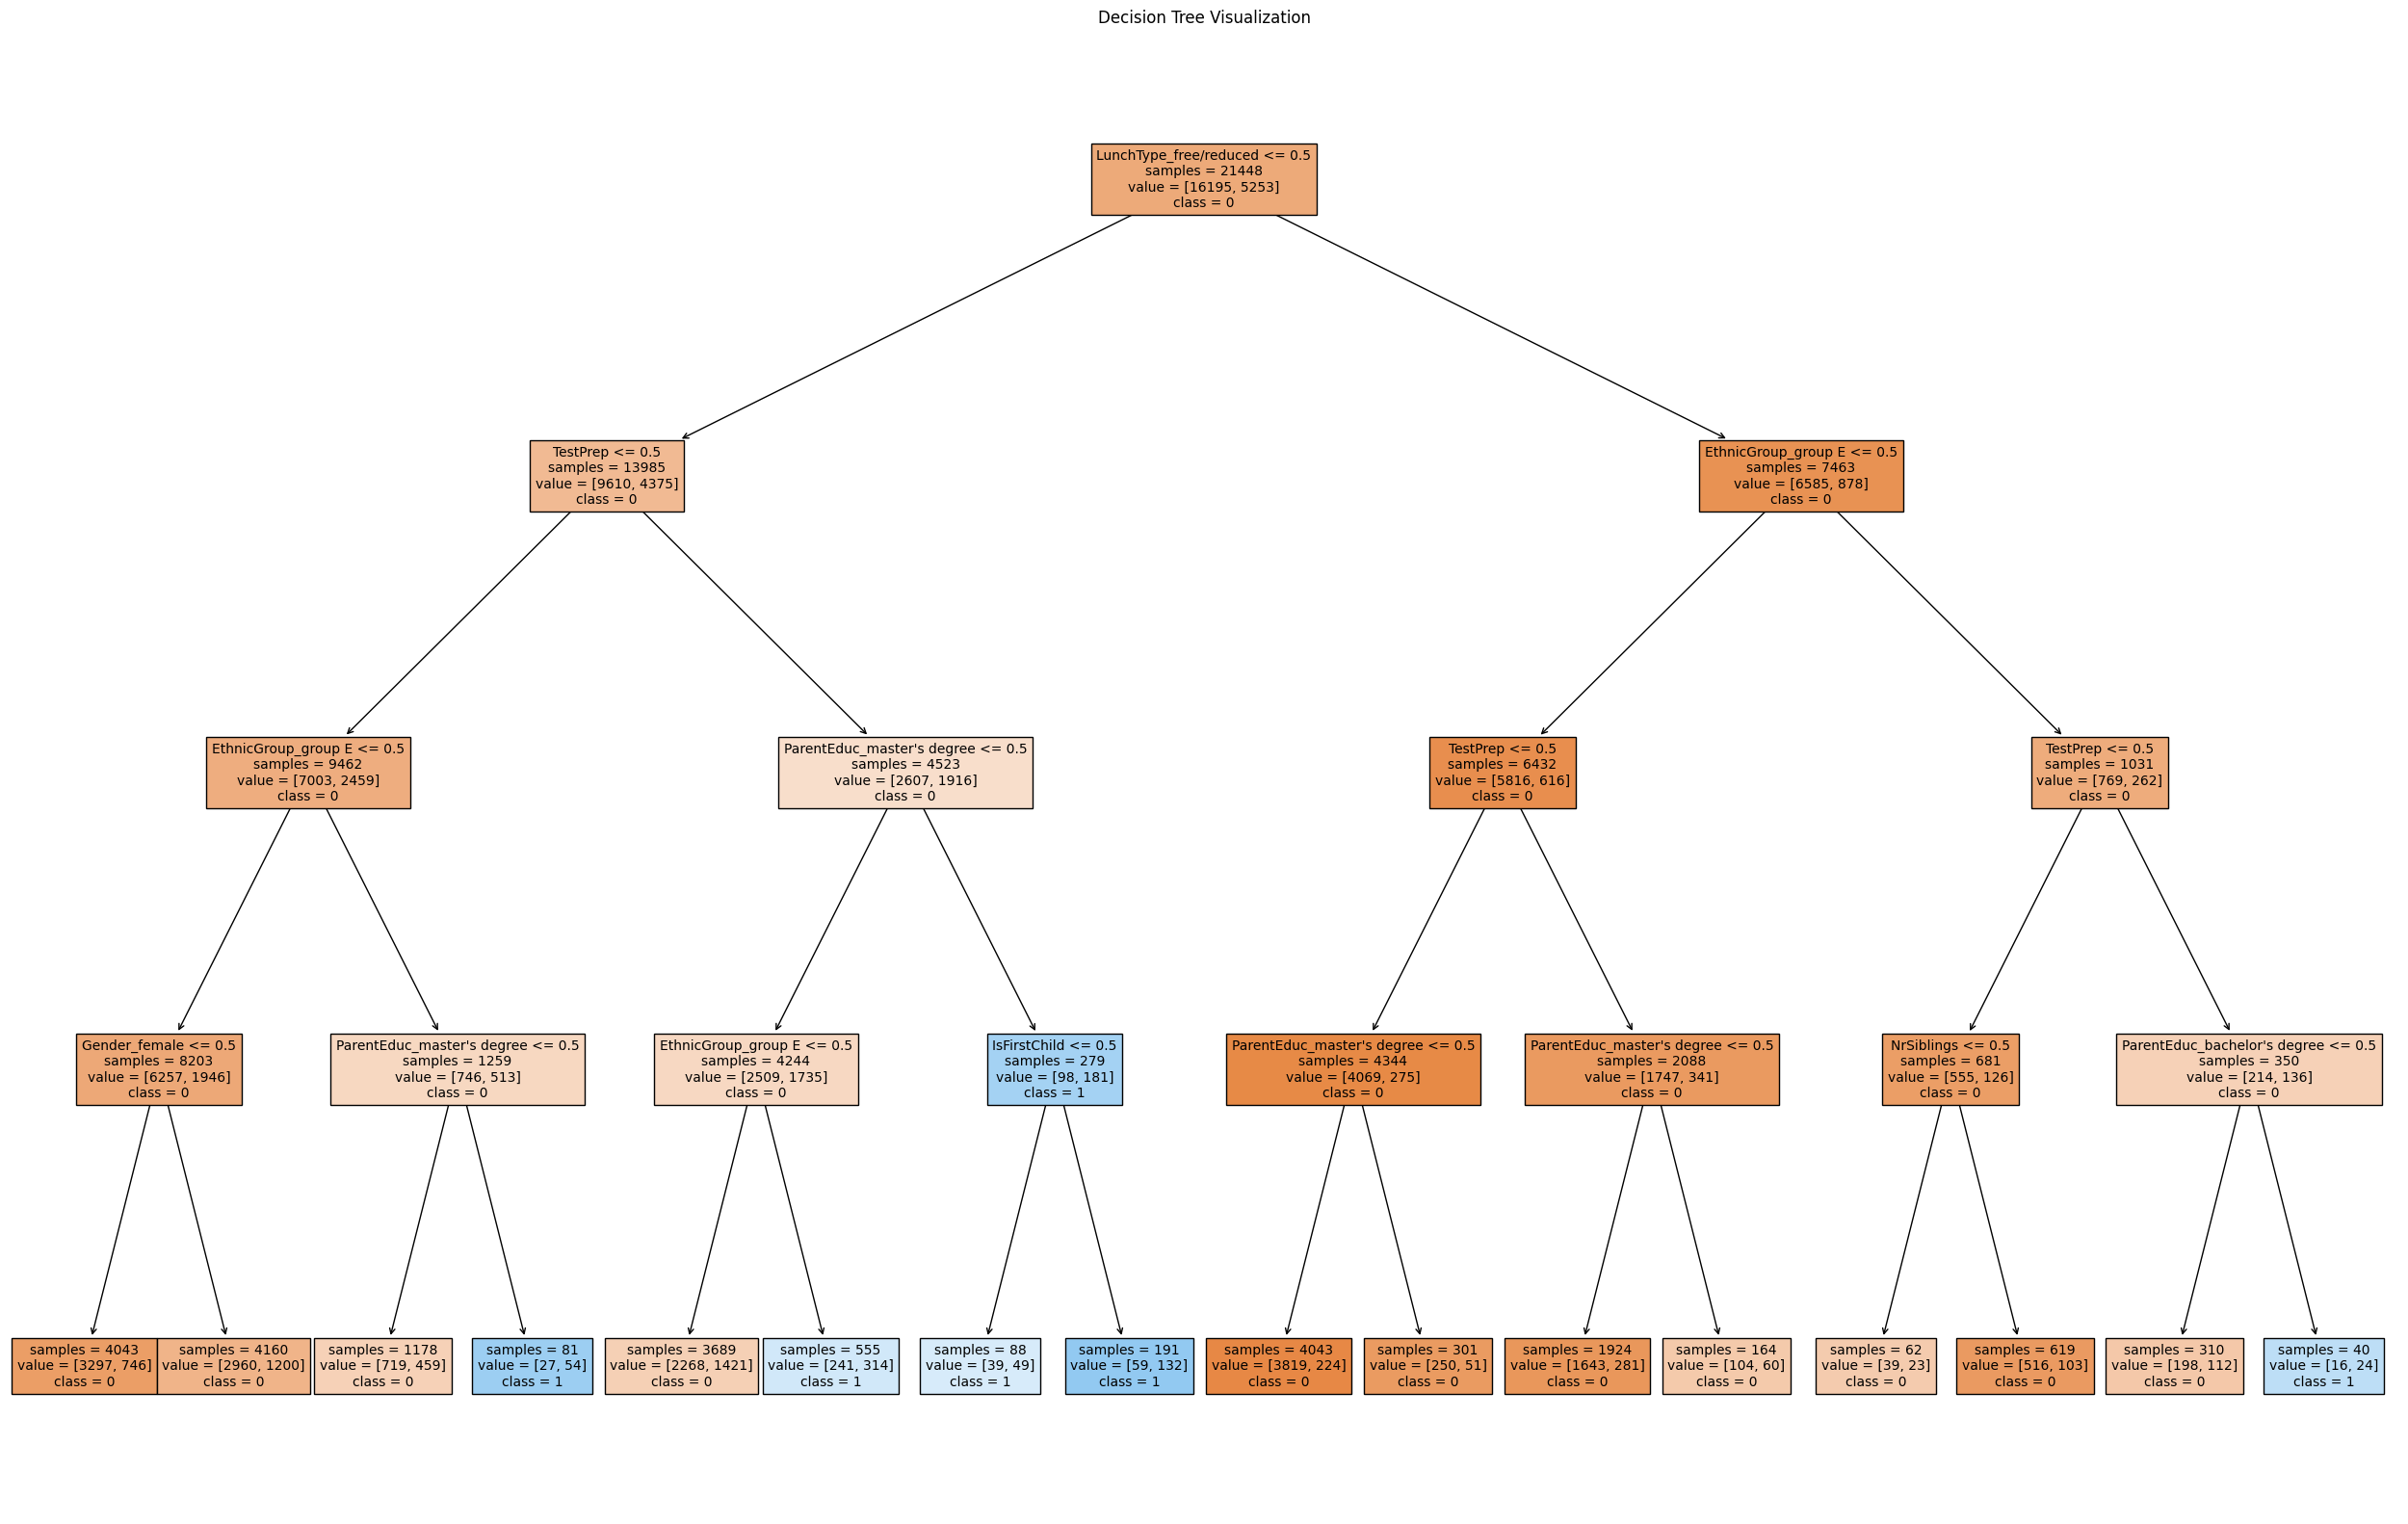

In [11]:
# Decision Tree logic plot  

plt.figure(figsize=(32, 20)) 
plot_tree(
    best_decision_tree,
    filled=True,
    feature_names=X_train.columns.tolist(),
    class_names=['0', '1'],
    fontsize=10,  
    impurity=False  
)
plt.title("Decision Tree Visualization")
plt.show()

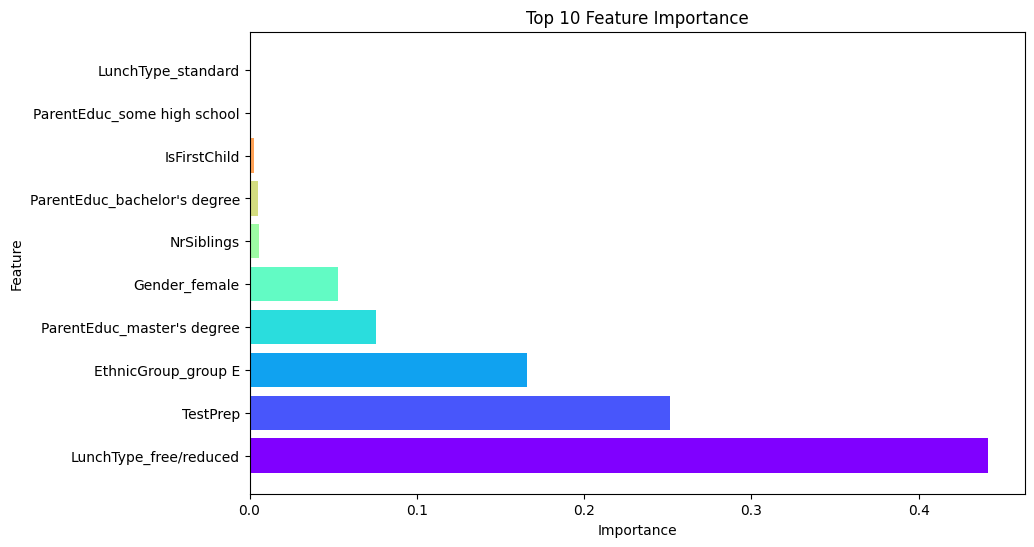

In [13]:
# Get feature importances from the best_decision_tree model
feature_importances = best_decision_tree.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_10_importance_df = importance_df.head(10)

# Plot the feature importances for the top 10 features
colors = cm.rainbow(np.linspace(0, 1, len(top_10_importance_df)))
plt.figure(figsize=(10, 6))
plt.barh(top_10_importance_df['Feature'], top_10_importance_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()

In [15]:
top_10_importance_df

,Feature,Importance
20,LunchType_free/reduced,0.441202
0,TestPrep,0.251592
10,EthnicGroup_group E,0.165733
17,ParentEduc_master's degree,0.075751
4,Gender_female,0.052720
2,NrSiblings,0.005613
15,ParentEduc_bachelor's degree,0.004804
1,IsFirstChild,0.002585
19,ParentEduc_some high school,0.000000
21,LunchType_standard,0.000000


## Next : Apply GAM